### Plasma Sheath, Cylindrical Langmuir Probe, Radial model

First, we set the kind of plasma. Uncomment the line that corresponds

RadioButtons(description='Plasma type:', options=('Argon and electrons', 'Neon and electrons', 'Helium and ele…

Text(value='')

<IPython.core.display.Javascript object>


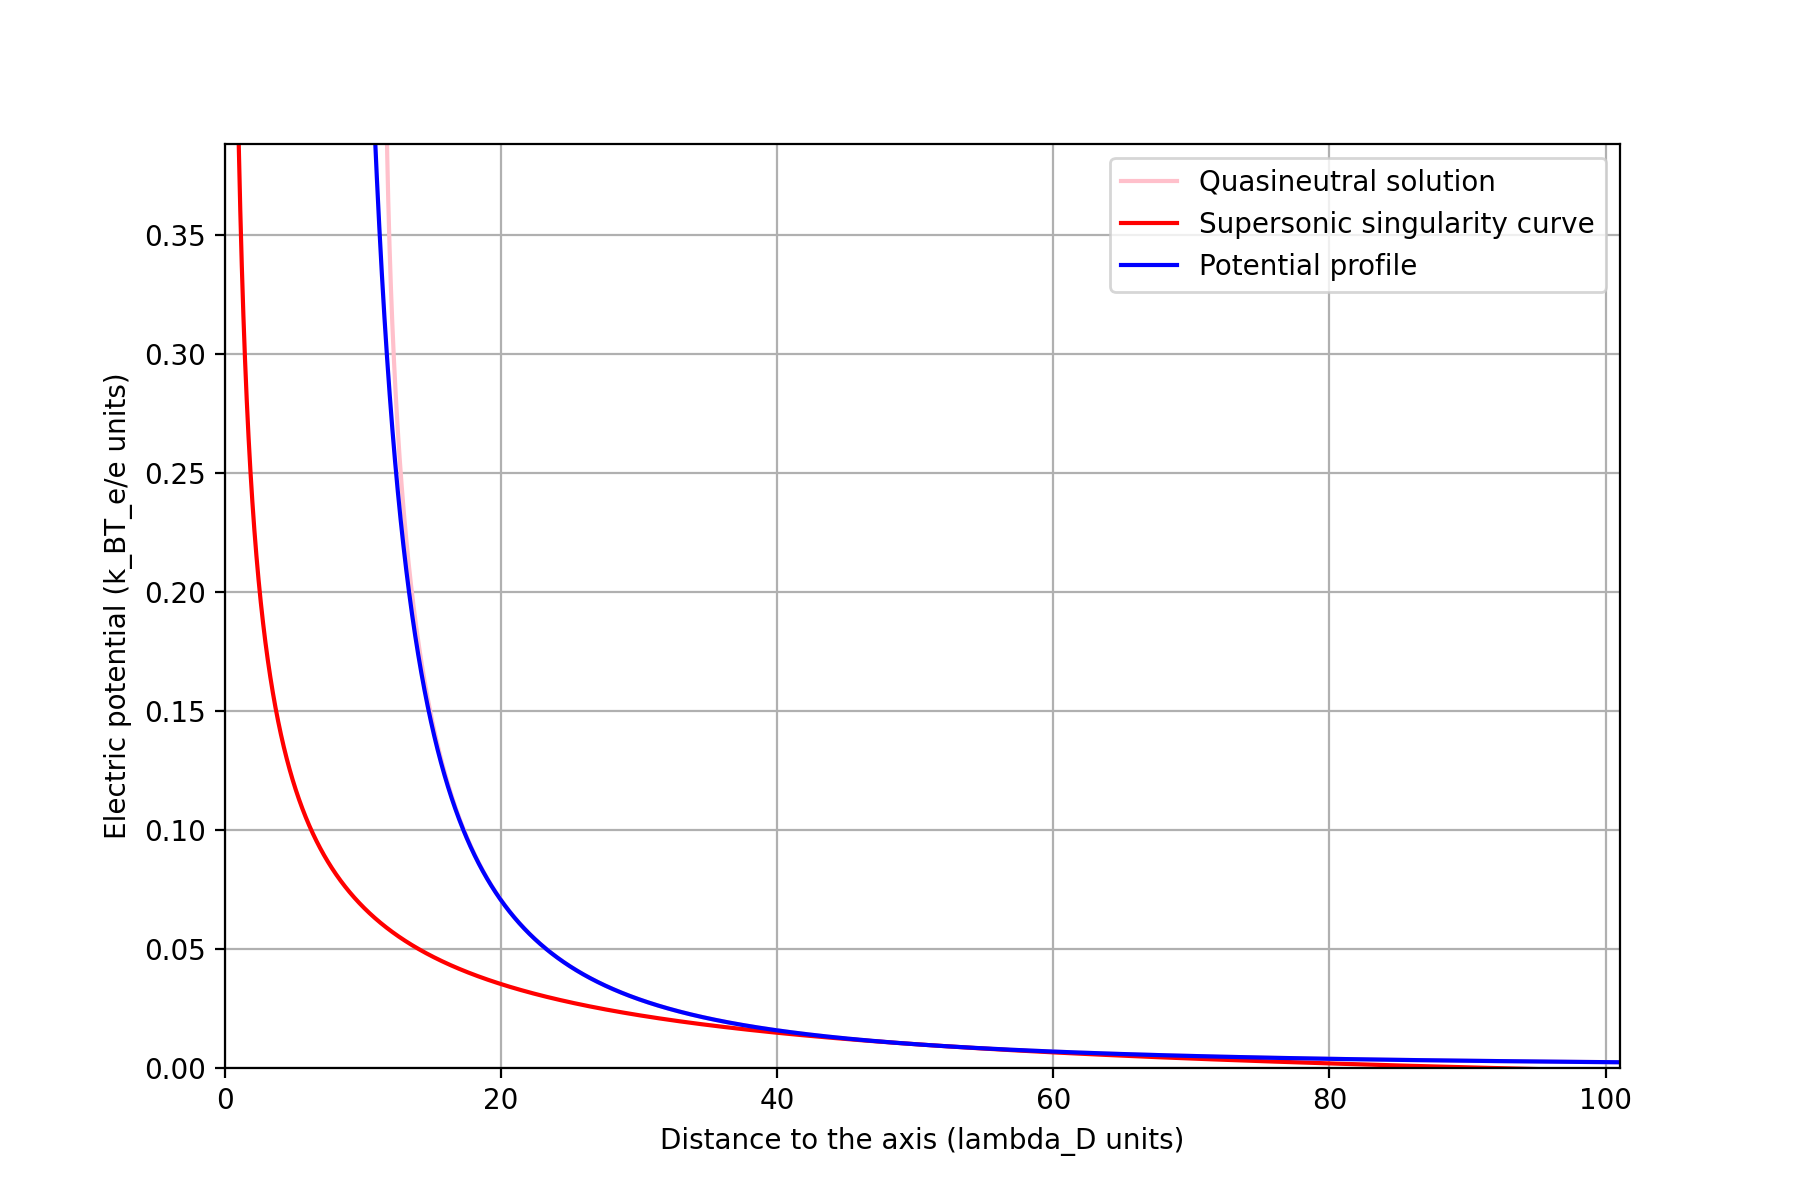

<IPython.core.display.Javascript object>


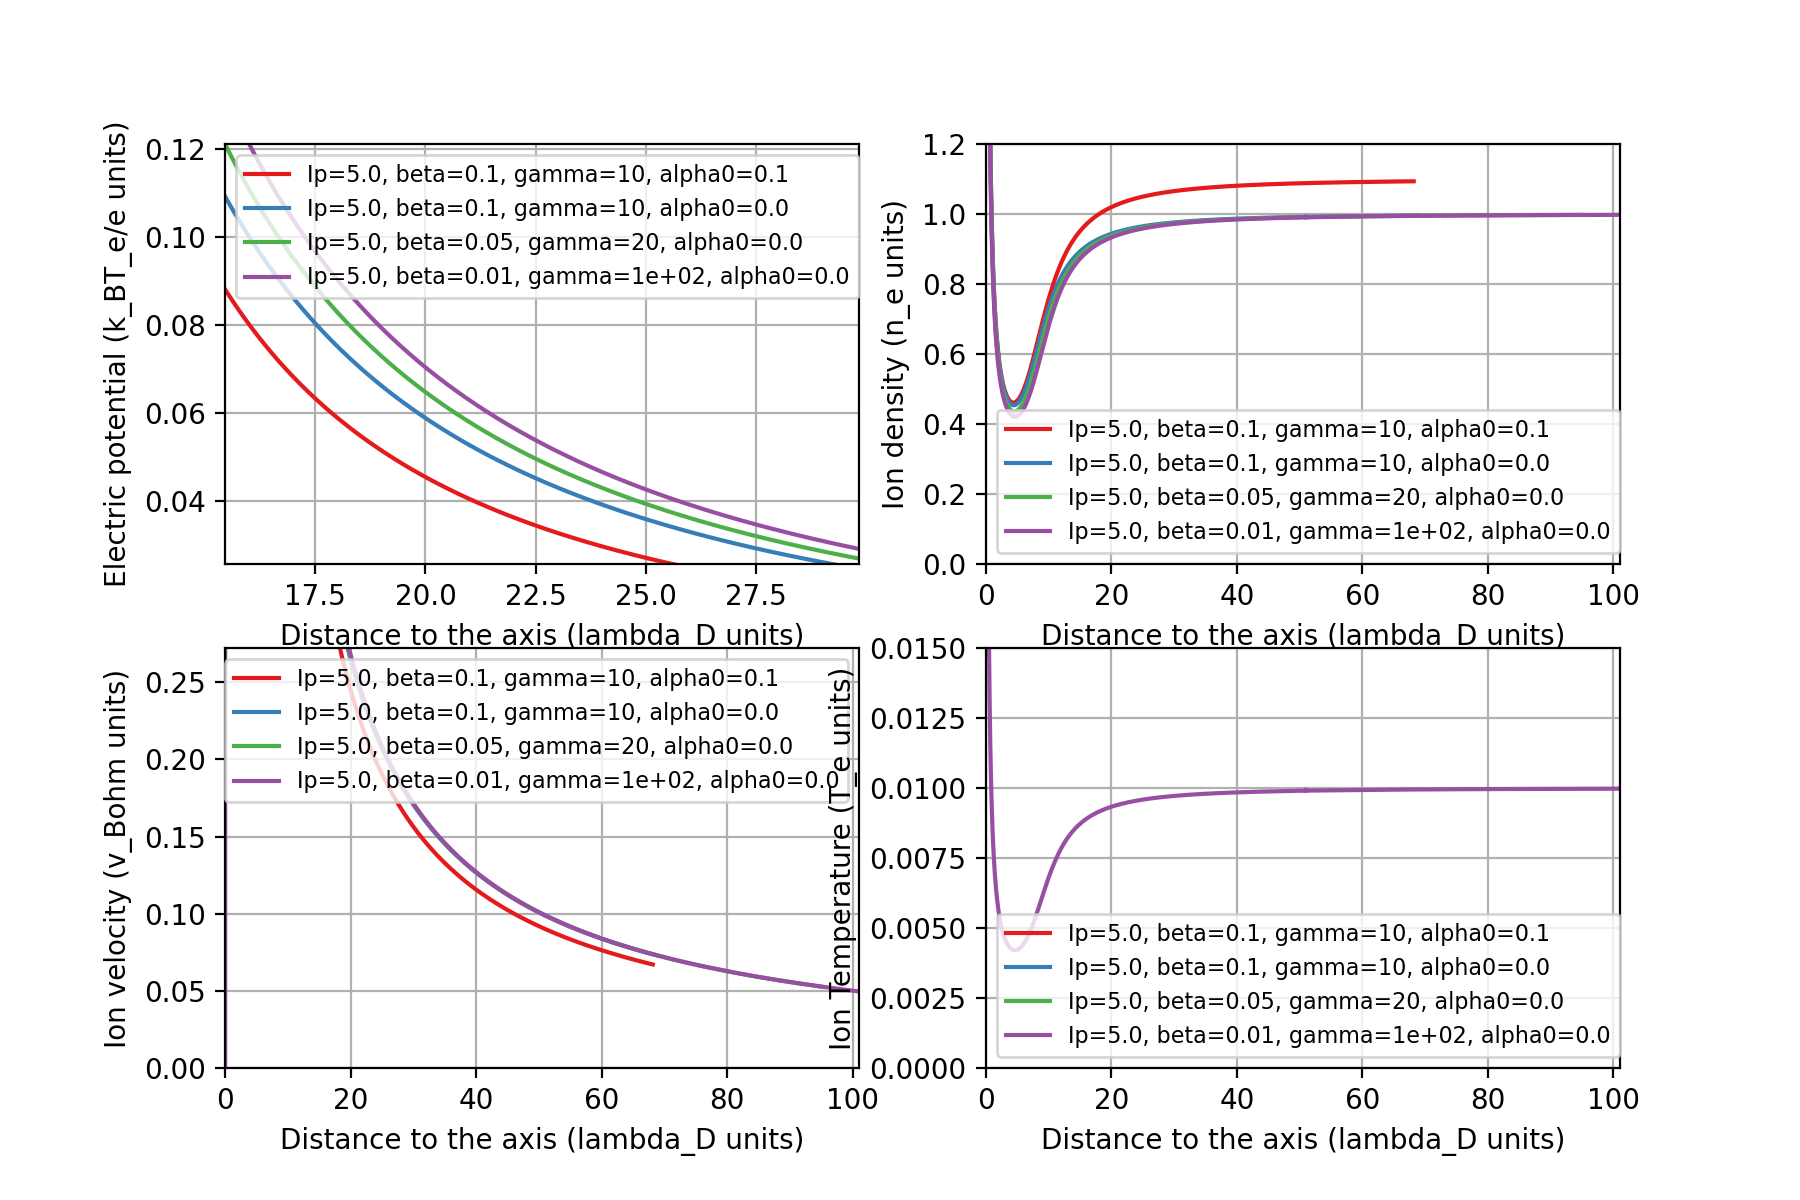

<IPython.core.display.Javascript object>


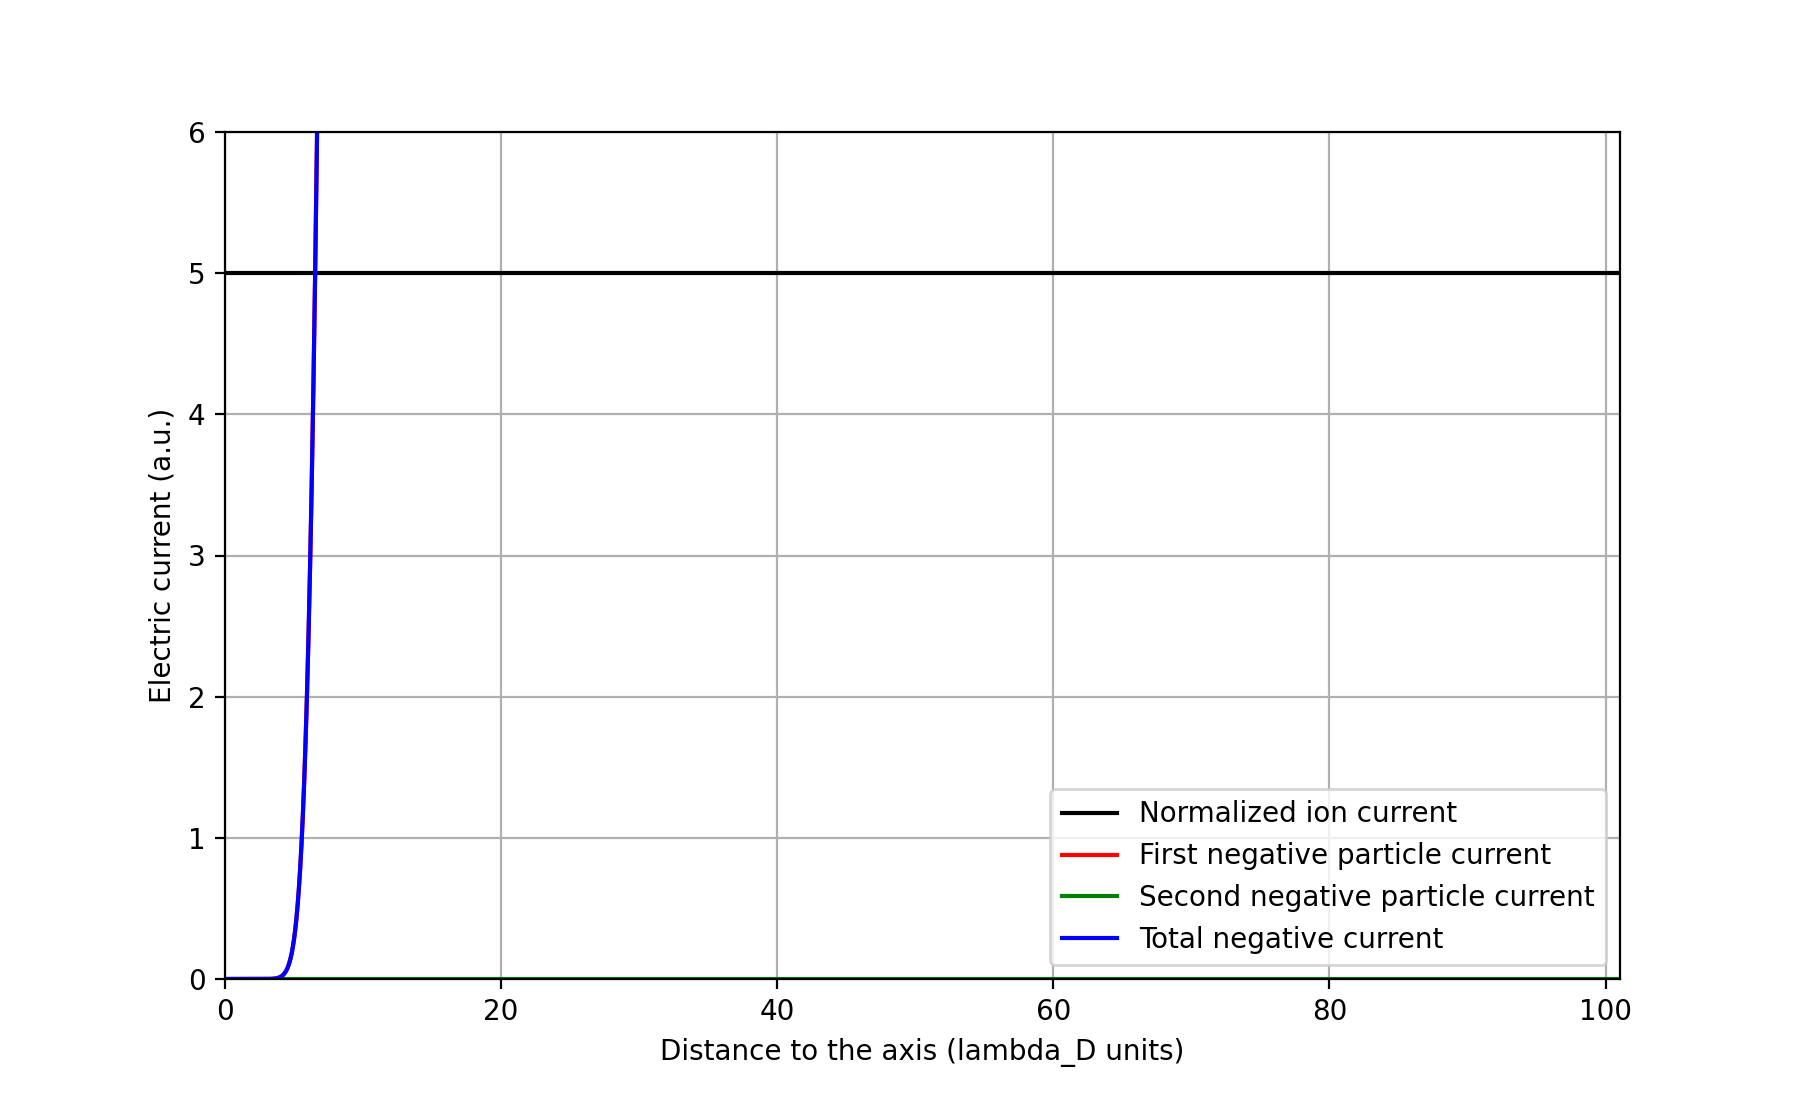

Text(value='', layout=Layout(width='90%'))

/Users/Billy/projects/jupyter/bg_sheath/functions.py:36: RuntimeWarning: overflow encountered in double_scalars
  return np.e**(-y) + alpha0*np.e**(-gamma*y)
/Users/Billy/projects/jupyter/bg_sheath/functions.py:118: RuntimeWarning: invalid value encountered in double_scalars
  y0 = 3*(beta*Ip/(x0*(1+alpha0)))**(2/3) - 2*beta
/Users/Billy/projects/jupyter/bg_sheath/functions.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return np.e**(-y) + alpha0*np.e**(-gamma*y)
/Users/Billy/projects/jupyter/bg_sheath/functions.py:157: RuntimeWarning: divide by zero encountered in double_scalars
  x = Ip/(c*np.sqrt(y-2*beta*(c/(1+alpha0)-1)))


In [1]:
import initialize
import sheath
import functions as f
import ipywidgets.widgets as widgets
import ipywidgets
from ipywidgets import Layout
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

# Display sliders and options
plasma_radio_buttons = widgets.RadioButtons(
    options=["Argon and electrons", "Neon and electrons", "Helium and electrons", "Oxygen O+ and O-"],
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Plasma type:')
display(plasma_radio_buttons)

bg = initialize.BetaGammaSheath()
bg.x_array = []
bg.y_array = []
bg.z_array = []
bg.N_array = []

Ip_slider = widgets.FloatSlider(value=5, min=1.5, max=100, step=0.1, description='Ip:')
beta_slider = widgets.FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description='beta:')
gamma_slider = widgets.FloatSlider(value=0.1, min=0.01, max=1.0, step=0.1, description='gamma_1:', disabled = True)
gamma_button = widgets.ToggleButton(description = "Link to beta", value = True)
alpha0_slider = widgets.FloatSlider(value=0.5, min=0.0, max=10.0, step=0.1, description='alpha0:')

gamma_line = widgets.HBox([gamma_slider, gamma_button])
dl = ipywidgets.jslink((beta_slider, 'value'), (gamma_slider, 'value'))

sliders = widgets.VBox([Ip_slider, beta_slider, gamma_line, alpha0_slider])
display(sliders)

run_button = widgets.Button(description = "Run calculation")
quasi_toogle_button = widgets.ToggleButton(value=True, description='Plot quasineutral')
supersonic_toogle_button = widgets.ToggleButton(value=True, description='Supersonic curve')
run_plot_buttons = widgets.HBox([run_button, quasi_toogle_button, supersonic_toogle_button])

display(run_plot_buttons)

info_text = widgets.Text()
display(info_text)

fig1, ax1 = plt.subplots(figsize=(9, 6))  # Create a figure containing a single axes.
ax1.set(xlabel='Distance to the axis (lambda_D units)', ylabel='Electric potential (k_BT_e/e units)')
ax1.grid(b = True)

fig2, ax2 = plt.subplots(2,2,figsize=(9, 6))  # Create a figure for the comparison of several parameters
ax2_11, ax2_12, ax2_21, ax2_22 = ax2.flatten()
ax2_11.grid(b = True)
ax2_11.set(xlabel='Distance to the axis (lambda_D units)', ylabel='Electric potential (k_BT_e/e units)')
ax2_12.grid(b = True)
ax2_12.set(xlabel='Distance to the axis (lambda_D units)', ylabel='Ion density (n_e units)')
ax2_21.grid(b = True)
ax2_21.set(xlabel='Distance to the axis (lambda_D units)', ylabel='Ion velocity (v_Bohm units)')
ax2_22.grid(b = True)
ax2_22.set(xlabel='Distance to the axis (lambda_D units)', ylabel='Ion Temperature (T_e units)')

fig3, ax3 = plt.subplots(figsize=(9, 5.5))  # Create a figure containing a single axes.
ax3.set(xlabel='Distance to the axis (lambda_D units)', ylabel='Electric current (Ip units)')
ax3.grid(b = True)

Vf_text = widgets.Text(layout=Layout(width='90%'))
display(Vf_text)

palette = plt.get_cmap('Set1')
i_palette = -1

def get_y_sing(x0a):
    '''Helper function to get singularity curve'''
    global bg
    [x0, y0, ydot0, xl] = f.getInitFloat(x0a, bg)
    return y0

def gamma_button_toggle(b):
    '''Helper function for gamma toggle button'''
    gamma_slider.disabled = gamma_button.value
    global dl
    dl.unlink()
    if gamma_slider.disabled:
        dl = ipywidgets.jslink((beta_slider, 'value'), (gamma_slider, 'value'))

gamma_button.observe(gamma_button_toggle)

def run_button_clicked(b):
    '''Helper function to pass arguments'''
    info_text.value = "Calculation in progress"
    
    # Pass parameters to bg
    global bg
    global i_palette
    bg.g.Ip = Ip_slider.value
    bg.g.beta = beta_slider.value
    bg.g.gamma = 1/gamma_slider.value
    bg.g.alpha0 = alpha0_slider.value
    bg.p = initialize.Plasma(plasma_radio_buttons.value)
    f.defineI0tuple(bg)
    sheath.cylindrical(bg) #Note that adimensional plasma sheath solution does not depend on the plasma type
    info_text.value = "Calculation finished"
    
    # Plot according to given options
    ax1.cla()
    ax1.grid(b = True)
    ax1.set(xlabel='Distance to the axis (lambda_D units)', ylabel='Electric potential (k_BT_e/e units)')

    # Quasineutral solution
    if quasi_toogle_button.value:
        bg.quasi_x_array = [f.getxCI(y, bg) for y in bg.y_array]
        ax1.plot(bg.quasi_x_array, bg.y_array, color='pink', label="Quasineutral solution")
    
    # Supersonic singularity curve
    if supersonic_toogle_button.value:
        bg.supersonic_y_array = [get_y_sing(x) for x in bg.x_array]
        ax1.plot(bg.x_array, bg.supersonic_y_array, color='red', label="Supersonic singularity curve")
    
    ax1.plot(bg.x_array, bg.y_array, color='blue', label="Potential profile")
    ax1.legend(prop={'size': 10})
    
    # Plot limits
    ax1.set_xlim(0, 1.1*bg.g.xl)
    ax1.set_ylim(0, 40*f.getylimit(bg))
    
    i_palette += 1
    # Plot other parameters, first potential again
    ax2_11.plot(bg.x_array, bg.y_array, color=palette(i_palette),
                label="Ip={0}, beta={1}, gamma={2:.2g}, alpha0={3}".format(bg.g.Ip, bg.g.beta, bg.g.gamma, bg.g.alpha0))
    ax2_11.set_xlim(0, 1.1*bg.g.xl)
    ax2_11.set_ylim(0, 40*f.getylimit(bg))
    ax2_11.legend(prop={'size': 8})
    ax2_11.set(xlabel='Distance to the axis (lambda_D units)', ylabel='Electric potential (k_BT_e/e units)')

    # Then ion density
    ax2_12.plot(bg.x_array, bg.N_array, color=palette(i_palette),
                label="Ip={0}, beta={1}, gamma={2:.2g}, alpha0={3}".format(bg.g.Ip, bg.g.beta, bg.g.gamma, bg.g.alpha0))
    ax2_12.set_xlim(0, 1.1*bg.g.xl)
    ax2_12.set_ylim(0, 1.2*(1 + bg.g.alpha0))
    ax2_12.legend(prop={'size': 8})
    ax2_12.set(xlabel='Distance to the axis (lambda_D units)', ylabel='Ion density (n_e units)')
    
    # Velocity
    ax2_21.plot(bg.x_array, bg.V_array, color=palette(i_palette),
                label="Ip={0}, beta={1}, gamma={2:.2g}, alpha0={3}".format(bg.g.Ip, bg.g.beta, bg.g.gamma, bg.g.alpha0))
    ax2_21.set_xlim(0, 1.1*bg.g.xl)
    ax2_21.set_ylim(0, 5*bg.g.Ip/bg.g.xl)
    ax2_21.legend(prop={'size': 8})
    ax2_21.set(xlabel='Distance to the axis (lambda_D units)', ylabel='Ion velocity (v_Bohm units)')

    # Local ion temperature
    ax2_22.plot(bg.x_array, bg.T_array, color=palette(i_palette),
                label="Ip={0}, beta={1}, gamma={2:.2g}, alpha0={3}".format(bg.g.Ip, bg.g.beta, bg.g.gamma, bg.g.alpha0))
    ax2_22.set_xlim(0, 1.1*bg.g.xl)
    ax2_22.set_ylim(0, 1.5*bg.g.beta)
    ax2_22.legend(prop={'size': 8})
    ax2_22.set(xlabel='Distance to the axis (lambda_D units)', ylabel='Ion Temperature (T_e units)')
    
    ax3.cla()
    ax3.grid(b = True)
    ax3.set(xlabel='Distance to the axis (lambda_D units)', ylabel='Electric current (a.u.)')
    ax3.plot([0, 1.1*bg.g.xl], [bg.g.Ip, bg.g.Ip], color='black', label="Normalized ion current")
    bg.I1_array = [bg.g.I01*np.e**(-y) for y in bg.y_array]
    bg.I2_array = [bg.g.I02*bg.g.alpha0*np.e**(-bg.g.gamma*y) for y in bg.y_array]
    bg.In_array = [bg.I1_array[i] + bg.I2_array[i] for i in range(len(bg.I1_array))]
    ax3.plot(bg.x_array, bg.I1_array, color='red', label="First negative particle current")
    ax3.plot(bg.x_array, bg.I2_array, color='green', label="Second negative particle current")
    ax3.plot(bg.x_array, bg.In_array, color='blue', label="Total negative current")
    ax3.legend(prop={'size': 10})
    ax3.set_xlim(0, 1.1*bg.g.xl)
    ax3.set_ylim(0, 1.2*bg.g.Ip)
    
    yf = f.findvaluev(bg.In_array, bg.y_array, bg.g.Ip)
    xf = f.findvaluev(bg.In_array, bg.x_array, bg.g.Ip)
    Vf_text.value = "yf = {0:.3g} (k_BT_e/e units) for a probe of radius xf = {1:.3g}".format(yf, xf)

run_button.on_click(run_button_clicked)

